# Compare Spectra with BG40

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 6th 2022
- last update : June  6th 2022 : Save in file


### 

    


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

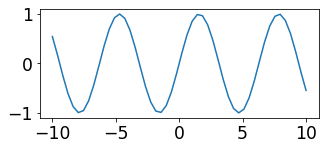

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-09'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

In [12]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [13]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)

## Dispersion relation X - wavelength
$$
x = D \frac{N_{eff} \lambda p}{\sqrt{1-(N_{eff} \lambda p)^2}}
$$

In [17]:
def Dispersion(wl,neff,D,p=1):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl*p/np.sqrt(1-(wl*neff*p)**2)
    return X


## Dispersion rate dX/d lambda
$$
\frac{dx}{d\lambda} = D N_{eff} p \frac{\sqrt{1-(N_{eff}\lambda p)^2} + \frac{(N_{eff} \lambda p)^2}{\sqrt{1-(N_{eff} \lambda p)^2} }}{1-(N_{eff} \lambda p)^2} 
$$

$$
\frac{dx}{d\lambda} = \frac{D N_{eff} p}{\left(1-(N_{eff} \lambda p)^2\right)^{\frac{3}{2}}} 
$$

In [18]:
def Dispersion_Rate(wl,neff,D,p=1):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    #dxdlambda=D*neff*p*(np.sqrt(1-(wl*neff*p)**2)+ (wl*neff*p)**2/np.sqrt(1-(wl*neff*p)**2))/(1-(wl*neff*p)**2)
    dxdlambda=D*neff*p/(np.sqrt(1-(wl*neff*p)**2))**3
    return dxdlambda 

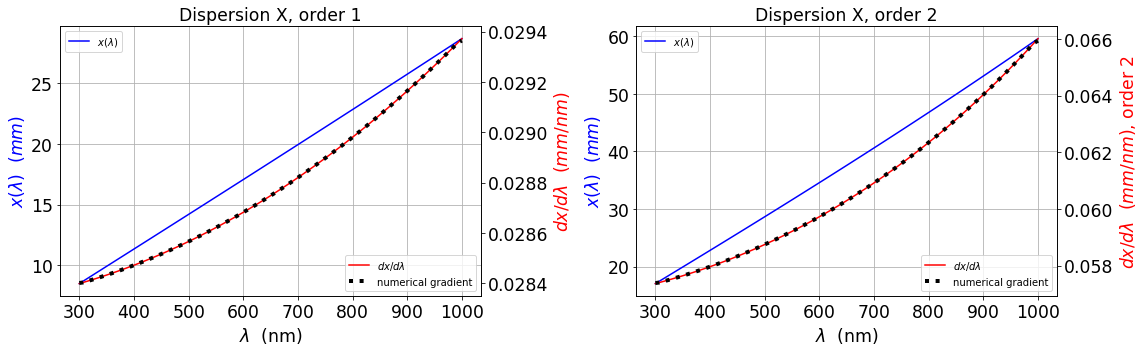

In [19]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

WL=np.linspace(300.,1000.,100)
neff=156. # lines per mm
D=184.45 # mm

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X, order 1")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


ax3 = fig.add_subplot(1,2,2)

Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")
ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax3.set_title("Dispersion X, order 2")
ax3.legend(loc="upper left")
ax3.grid()


ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)*1e-6 ## mm per nm
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($mm/ nm$), order 2",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")
#ax2.grid()


plt.tight_layout()


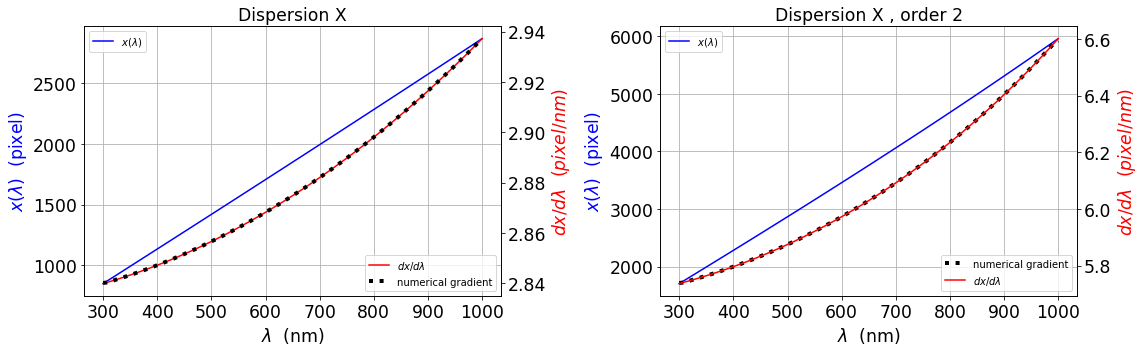

In [20]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()



ax3 = fig.add_subplot(1,2,2)


Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)/PIXELW   # pixel
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")

ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax3.set_title("Dispersion X , order 2")
ax3.legend(loc="upper left")
ax3.grid()

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)/PIXELW*1e-6   # pixel per nm
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")

plt.tight_layout()

## Multiplicative factor

$$
\frac{\left(\frac{dx}{d\lambda}\right)_{order =2}}{\left(\frac{dx}{d\lambda}\right)_{order =1}}
$$

Text(0.5, 1.0, 'Multiplicative factor order 2/order1 ')

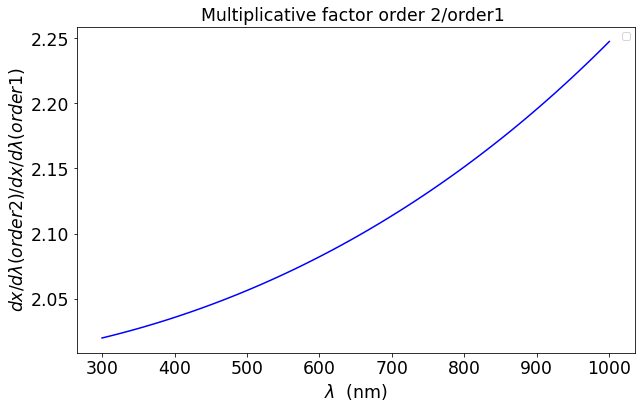

In [21]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,1,1)
latexlabel = "$\frac{\left(\frac{dx}{d\lambda}\right)_{order=2}}{\left(\frac{dx}{d\lambda}\right)_{order=1}}$"
ax1.plot(WL,Y4/Y2,"b-")
ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$dx/d\lambda(order2) / dx/d\lambda(order 1) $")
ax1.legend()
ax1.set_title("Multiplicative factor order 2/order1 ")

In [22]:
f_o2o1=interpolate.interp1d(WL,Y4/Y2,bounds_error=False,fill_value="extrapolate")

# Config

- spectrum need config

In [23]:
load_config("../runspectractor_standalone/2022_05/config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini")

No rebinning: parameters.REBIN is forced to 1.


In [24]:
# path index for each month
DATE="20211104"

# Calibration Lines

https://en.wikipedia.org/wiki/Balmer_series

In [25]:
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=False)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)



In [26]:
my_calib_lines = Lines([HBETA,HGAMMA,HDELTA,HEPSILON,HZETA,HETA,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [27]:
top_path = "/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D"

In [28]:
#! ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104

In [29]:
#exposure = "2021110400263"  # HD205905
#exposure = "2021110400274"   # HD009051 , creazy results
#exposure ="2021110400508"  # ETADOR
#exposure = "2021110400519"  # HD38949
#exposure = "2021110400542"   # HD031128
#exposure = "2021110400553"    #Mu Col
#exposure = "2021110400564"   # HD38949

In [30]:
Exposure_to_target = {"2021110400263":"HD205905",
                     "2021110400274":"HD009051",
                     "2021110400508":"ETA1 DOR",
                     "2021110400519":"HD38949",
                     "2021110400542":"HD031128",
                     "2021110400553":"mu. Col",
                     "2021110400564":"HD38949"}                     

In [31]:
Target_to_exposure = dict((v, k) for k, v in Exposure_to_target.items())
Target_to_exposure

{'HD205905': '2021110400263',
 'HD009051': '2021110400274',
 'ETA1 DOR': '2021110400508',
 'HD38949': '2021110400564',
 'HD031128': '2021110400542',
 'mu. Col': '2021110400553'}

In [32]:
list_of_exposures = list(Exposure_to_target.keys())
list_of_exposures

['2021110400263',
 '2021110400274',
 '2021110400508',
 '2021110400519',
 '2021110400542',
 '2021110400553',
 '2021110400564']

In [33]:
list_of_exposures_targets = list(Exposure_to_target.items())
list_of_exposures_targets

[('2021110400263', 'HD205905'),
 ('2021110400274', 'HD009051'),
 ('2021110400508', 'ETA1 DOR'),
 ('2021110400519', 'HD38949'),
 ('2021110400542', 'HD031128'),
 ('2021110400553', 'mu. Col'),
 ('2021110400564', 'HD38949')]

In [34]:
all_fullpath = [ os.path.join(os.path.join(os.path.join(top_path,DATE),exposure),"basespec") for exposure in list_of_exposures]
all_fullpath 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400263/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400274/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400519/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400542/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400553/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400564/basespec']

## Read Spectra

In [35]:
!ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400263/basespec

exposure_2021110400263_postisrccd_lines.csv
exposure_2021110400263_postisrccd_spectrogram.fits
exposure_2021110400263_postisrccd_spectrum.fits
exposure_2021110400263_postisrccd_table.csv


In [36]:
all_spectra = []
for file_fullpath in all_fullpath: 
    list_of_files = sorted(os.listdir(file_fullpath))
    print(list_of_files)
    spectrum = Spectrum(os.path.join(file_fullpath,list_of_files[2]))
    spectrum.lines = my_calib_lines 
    calibrate_spectrum(spectrum, with_adr=False)
    all_spectra.append(spectrum)

['exposure_2021110400263_postisrccd_lines.csv', 'exposure_2021110400263_postisrccd_spectrogram.fits', 'exposure_2021110400263_postisrccd_spectrum.fits', 'exposure_2021110400263_postisrccd_table.csv']
set date_obs to 2021-11-05T01:43:31.722
set expo to 20.0
set airmass to 1.156770779362235
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.3065833333333
set hour_angle to 34.4454279916179
set temperature to 5.8
set pressure to 741.05
set humidity to 49.0
set lambda_ref to 571.8069014788438
set parallactic_angle to 103.8799996934361


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = HD205905, Selected object name for Simbad : HD205905
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1


2022-06-09 10:33:18  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


['exposure_2021110400274_postisrccd_lines.csv', 'exposure_2021110400274_postisrccd_spectrogram.fits', 'exposure_2021110400274_postisrccd_spectrum.fits', 'exposure_2021110400274_postisrccd_table.csv']
set date_obs to 2021-11-05T01:51:23.948
set expo to 20.0
set airmass to 1.06037825874769
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -24.3403888888889
set hour_angle to -20.93456535541785
set temperature to 5.9
set pressure to 741.1
set humidity to 47.0
set lambda_ref to 576.3774338842832
set parallactic_angle to -112.2644694071151
target_name = HD009051, Selected object name for Simbad : HD009051
 MAIN_ID        RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD   9051 01 28 46.5026 -24 20 25.442 ... -0.0002390                1


2022-06-09 10:34:05  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


['exposure_2021110400508_postisrccd_lines.csv', 'exposure_2021110400508_postisrccd_spectrogram.fits', 'exposure_2021110400508_postisrccd_spectrum.fits', 'exposure_2021110400508_postisrccd_table.csv']
set date_obs to 2021-11-05T04:49:33.916
set expo to 20.0
set airmass to 1.41214447333932
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -66.0397222222222
set hour_angle to -45.38165160354449
set temperature to 5.6
set pressure to 740.35
set humidity to 37.0
set lambda_ref to 572.0006264477072
set parallactic_angle to -60.35656136093252
target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ... Z_VALUE_3 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


2022-06-09 10:35:16  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


['exposure_2021110400519_postisrccd_lines.csv', 'exposure_2021110400519_postisrccd_spectrogram.fits', 'exposure_2021110400519_postisrccd_spectrum.fits', 'exposure_2021110400519_postisrccd_table.csv']
set date_obs to 2021-11-05T04:56:25.517
set expo to 20.0
set airmass to 1.22352411418254
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -24.4638611111111
set hour_angle to -39.41205206196119
set temperature to 5.7
set pressure to 740.3
set humidity to 36.0
set lambda_ref to 576.3672909161895
set parallactic_angle to -108.3644617329875
target_name = HD38949, Selected object name for Simbad : HD38949
 MAIN_ID        RA           DEC      ... Z_VALUE_4 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD  38949 05 48 20.0587 -24 27 49.853 ... 0.0000110                1


2022-06-09 10:36:32  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


['exposure_2021110400542_postisrccd_lines.csv', 'exposure_2021110400542_postisrccd_spectrogram.fits', 'exposure_2021110400542_postisrccd_spectrum.fits', 'exposure_2021110400542_postisrccd_table.csv']
set date_obs to 2021-11-05T05:13:18.245
set expo to 20.0
set airmass to 1.055727084282435
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.0641388888889
set hour_angle to -21.138660000471
set temperature to 5.7
set pressure to 740.15
set humidity to 39.0
set lambda_ref to 576.4222017624951
set parallactic_angle to -104.7343406955139
target_name = HD031128, Selected object name for Simbad : HD031128
 MAIN_ID        RA           DEC      ... Z_VALUE_5 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD  31128 04 52 09.9097 -27 03 50.940 ... 0.0003730                1


2022-06-09 10:37:12  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


['exposure_2021110400553_postisrccd_lines.csv', 'exposure_2021110400553_postisrccd_spectrogram.fits', 'exposure_2021110400553_postisrccd_spectrum.fits', 'exposure_2021110400553_postisrccd_table.csv']
set date_obs to 2021-11-05T05:19:40.563
set expo to 20.0
set airmass to 1.133031268393535
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -32.3064444444444
set hour_angle to -32.9809107379554
set temperature to 5.9
set pressure to 740.15
set humidity to 29.0
set lambda_ref to 580.2256388744363
set parallactic_angle to -94.67117786930913
target_name = mu.col, Selected object name for Simbad : mu. Col
 MAIN_ID        RA           DEC      ... Z_VALUE_6 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1


2022-06-09 10:38:05  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


['exposure_2021110400564_postisrccd_lines.csv', 'exposure_2021110400564_postisrccd_spectrogram.fits', 'exposure_2021110400564_postisrccd_spectrum.fits', 'exposure_2021110400564_postisrccd_table.csv']
set date_obs to 2021-11-05T05:26:02.798
set expo to 20.0
set airmass to 1.140952399262215
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -24.4638611111111
set hour_angle to -31.98737100197744
set temperature to 5.8
set pressure to 740.05
set humidity to 29.0
set lambda_ref to 575.267969843926
set parallactic_angle to -108.7161237037516
target_name = HD38949, Selected object name for Simbad : HD38949
 MAIN_ID        RA           DEC      ... Z_VALUE_7 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD  38949 05 48 20.0587 -24 27 49.853 ... 0.0000110                1


2022-06-09 10:39:34  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


In [37]:
from spectractor.tools import plot_spectrum_simple

(0.0, 8e-11)

<Figure size 864x576 with 0 Axes>

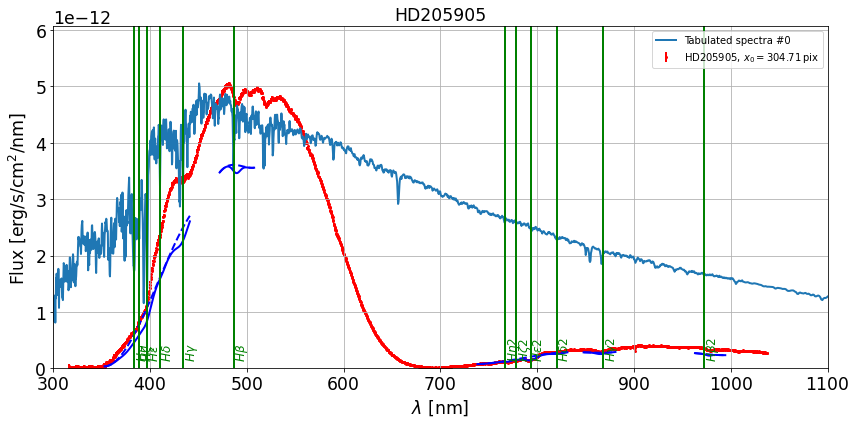

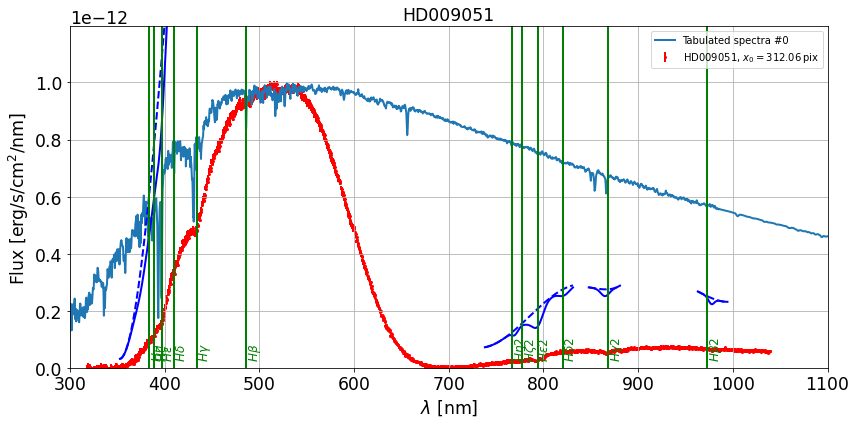

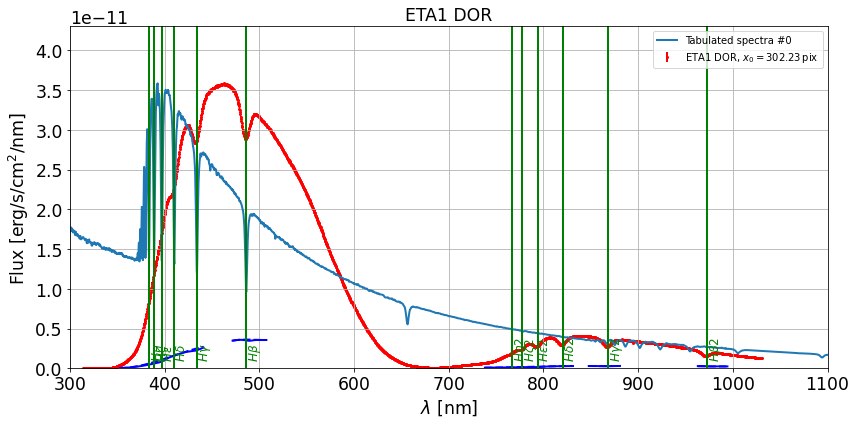

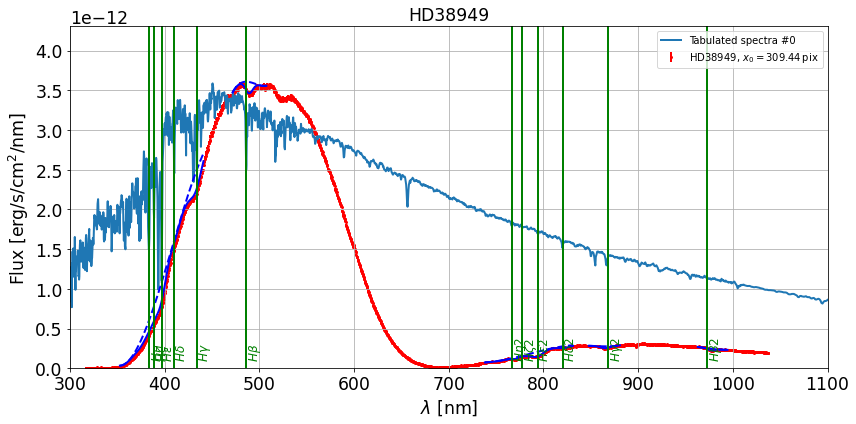

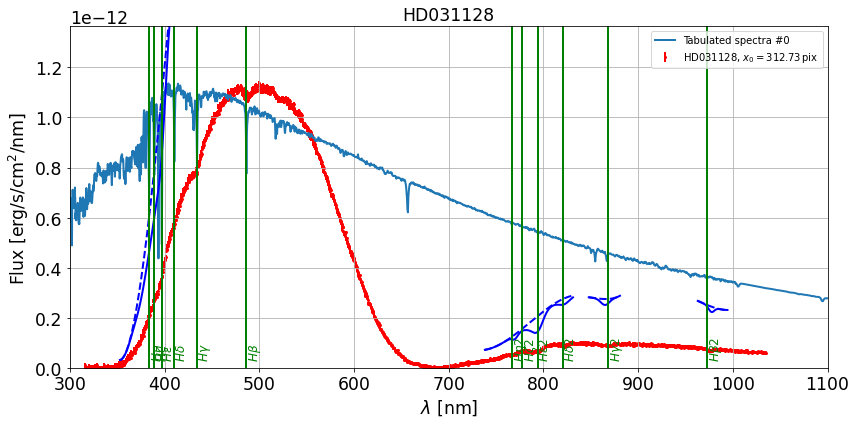

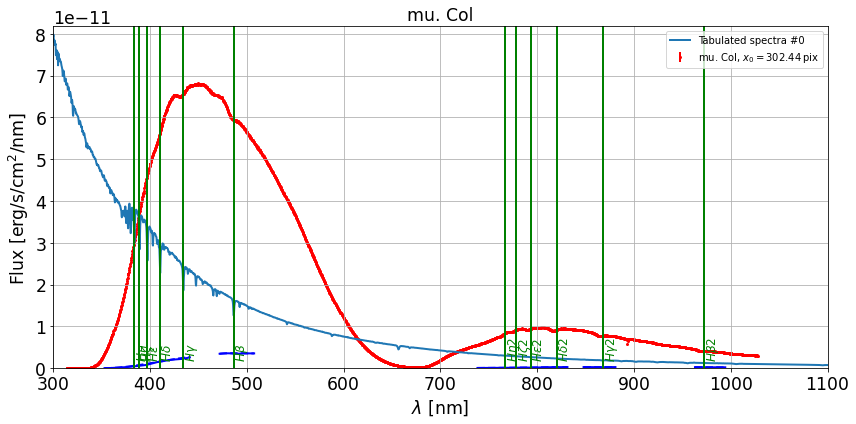

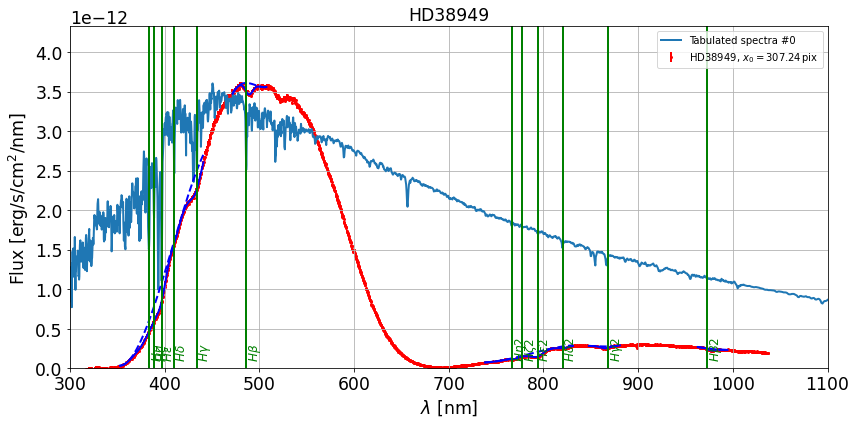

In [38]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.color_palette("hls", len(all_spectra))


for spectrum in all_spectra:
    spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=spectrum.target.label)
ax.set_ylim(0,0.8e-10)

(0.0, 8e-11)

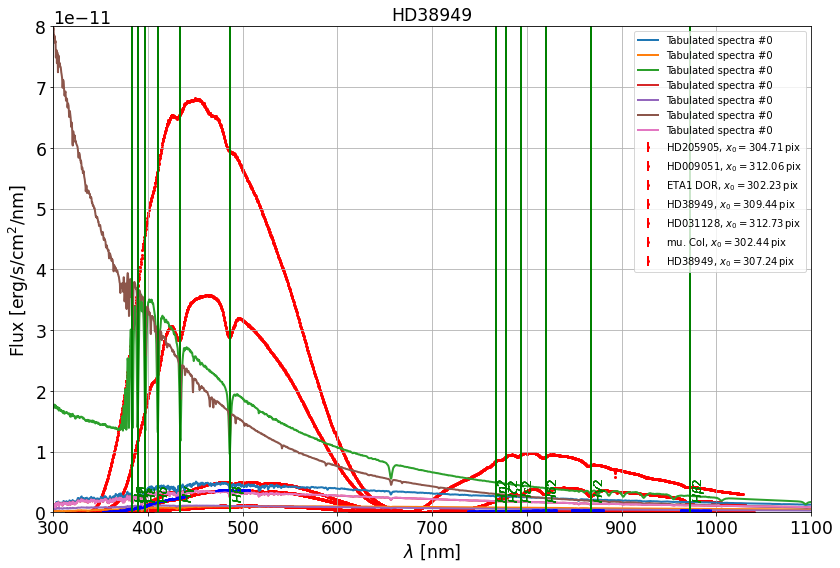

In [39]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.color_palette("hls", len(all_spectra))
ax = fig.add_subplot(1,1,1)

for spectrum in all_spectra:
    spectrum.plot_spectrum(ax=ax,xlim=[300,1100], live_fit=False, force_lines=True,label=spectrum.target.label)
ax.set_ylim(0,0.8e-10)

Text(0.5, 1.0, 'Fluxes through BG 40 ')

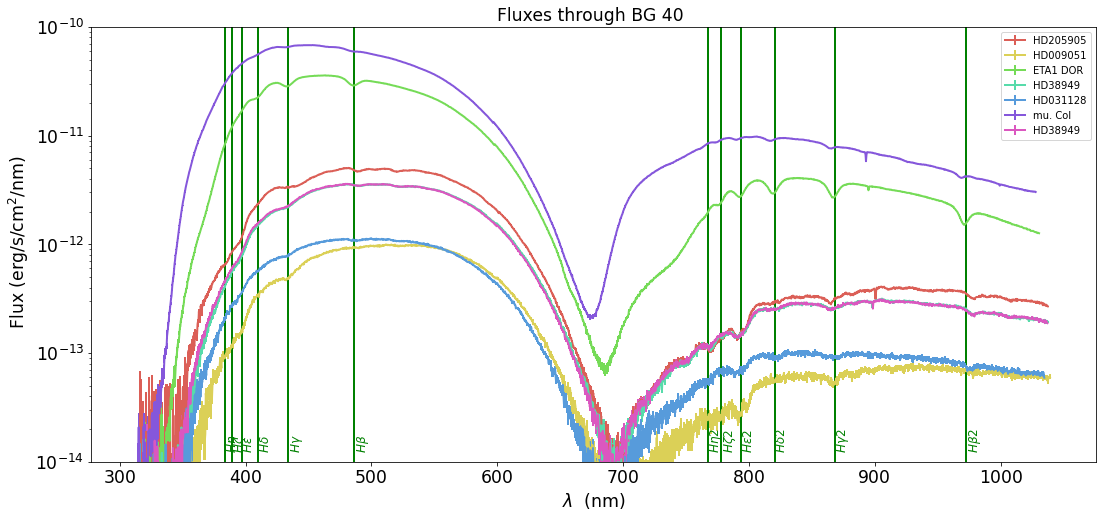

In [40]:
import seaborn as sns
fig = plt.figure(figsize=(18,8))
color_list = sns.color_palette("hls", len(all_spectra))
ax = fig.add_subplot(1,1,1)

idx=0
for spectrum in all_spectra:
    spectrum.lines = my_calib_lines 
    targetname = spectrum.target.label
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    if targetname == "ETA1 DOR":
        spectrum.lines.plot_atomic_lines(ax=ax)
    idx+=1
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-14,1e-10)
ax.set_xlabel("$\lambda$  (nm)")
ax.set_ylabel(f" Flux ({spectrum.units})")
ax.set_title("Fluxes through BG 40 ")

# Adjust Lines for wavelength calibration

- add line one by one in the fit.
The lines to include may depend on the spectrum

In [41]:
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

In [42]:
my_calib_lines_v2 = Lines([HBETA,HGAMMA,HDELTA,HEPSILON,HZETA,HETA,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [43]:
my_calib_lines_etador = Lines([HBETA,HGAMMA,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_mucol = Lines([HBETA,HGAMMA,HGAMMA2,HDELTA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd205905 = Lines([HBETA,HGAMMA,HBETA2,HGAMMA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd009051 = Lines([HBETA,HGAMMA],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd38949 = Lines([HBETA,HGAMMA],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd031128 = Lines([HBETA,HGAMMA],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [44]:
for spectrum in all_spectra:
    targetname = spectrum.target.label
    print(targetname)

HD205905
HD009051
ETA1 DOR
HD38949
HD031128
mu. Col
HD38949


2022-06-09 10:55:35  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2022-06-09 10:56:09  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2022-06-09 10:56:35  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2022-06-09 10:57:33  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2022-06-09 10:58:02  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2022-06-09 10:58:27  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to 

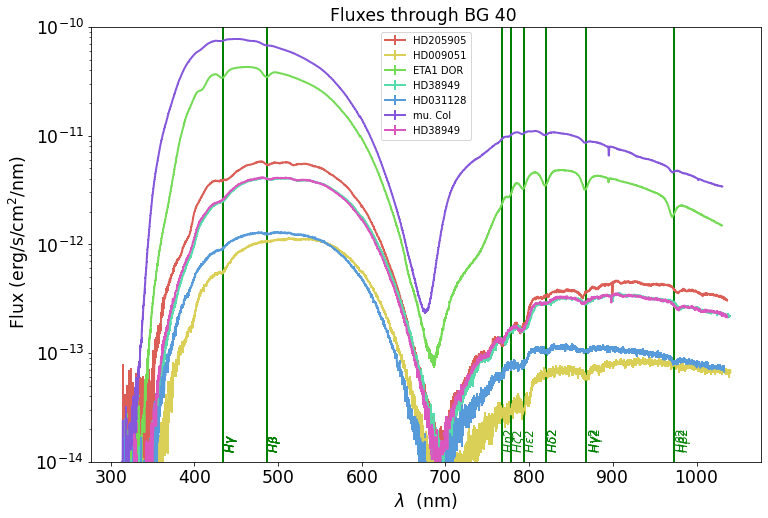

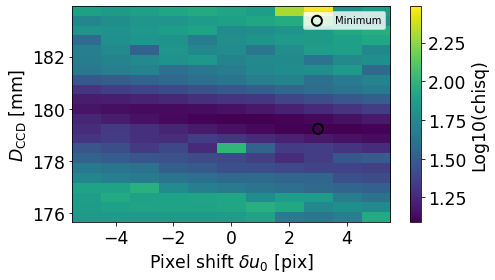

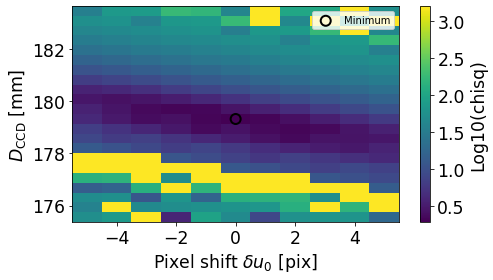

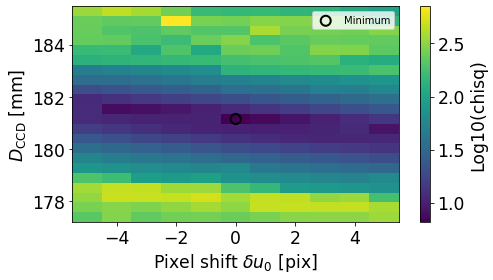

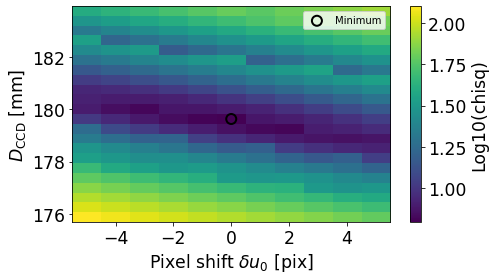

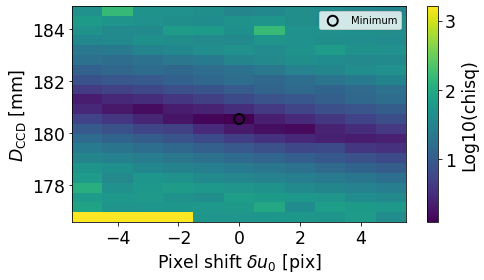

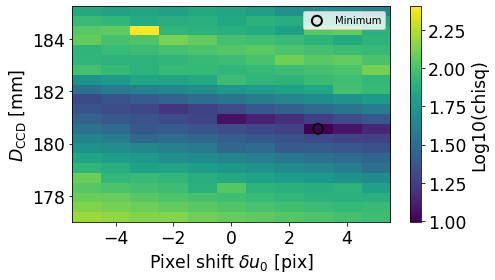

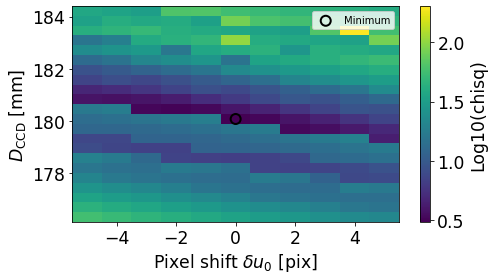

In [50]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
color_list = sns.color_palette("hls", len(all_spectra))
ax = fig.add_subplot(1,1,1)

idx=0
for spectrum in all_spectra:
    targetname = spectrum.target.label
    if targetname == "ETA1 DOR":
        spectrum.lines = my_calib_lines_etador 
        calibrate_spectrum(spectrum, with_adr=False)
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
        spectrum.lines.plot_atomic_lines(ax=ax)
    if targetname == "mu. Col":
        spectrum.lines = my_calib_lines_mucol 
        calibrate_spectrum(spectrum, with_adr=False)
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
        spectrum.lines.plot_atomic_lines(ax=ax)
    if targetname == "HD205905":
        spectrum.lines = my_calib_lines_hd205905 
        calibrate_spectrum(spectrum, with_adr=False)
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
        spectrum.lines.plot_atomic_lines(ax=ax)
    if targetname == "HD009051":
        spectrum.lines = my_calib_lines_hd009051 
        calibrate_spectrum(spectrum, with_adr=False)
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
        spectrum.lines.plot_atomic_lines(ax=ax)
    if targetname == "HD38949":
        spectrum.lines = my_calib_lines_hd38949 
        calibrate_spectrum(spectrum, with_adr=False)
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
        spectrum.lines.plot_atomic_lines(ax=ax)
    if targetname == "HD031128":
        spectrum.lines = my_calib_lines_hd031128  
        calibrate_spectrum(spectrum, with_adr=False)
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
        spectrum.lines.plot_atomic_lines(ax=ax)
        
        
        
    idx+=1
ax.legend()
#ax.set_yscale("log")
ax.set_ylim(1e-14,1e-10)
ax.set_xlabel("$\lambda$  (nm)")
ax.set_ylabel(f" Flux ({spectrum.units})")
ax.set_title("Fluxes through BG 40 ")

ax.set_yscale("log")

2021110400508_ETA1 DOR_spectrum.fits
HD205905
HD009051
ETA1 DOR


2022-06-09 10:45:33  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


HD38949
HD031128
mu. Col
HD38949


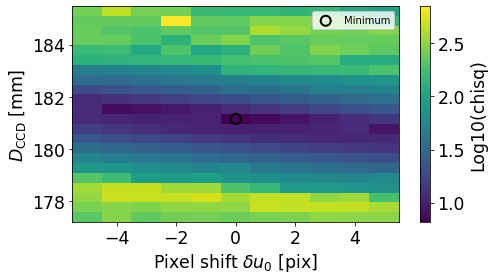

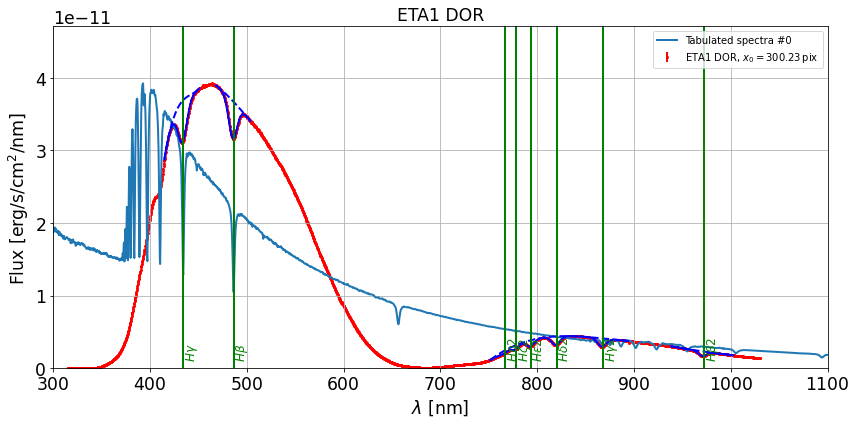

In [46]:
#TARGETSEL = "HD031128"
#TARGETSEL = "HD38949"
#TARGETSEL = "HD009051" 
#TARGETSEL = "HD205905"
#TARGETSEL = "mu. Col"
TARGETSEL = "ETA1 DOR"
EXPO=Target_to_exposure[TARGETSEL]

file_out = EXPO+"_"+TARGETSEL.strip().upper()+"_spectrum.fits"
path_out = "./recalibspectra"
full_file_out = os.path.join(path_out,file_out) 

print(file_out)

for spectrum in all_spectra:
    targetname = spectrum.target.label
    print(targetname)

    if targetname == "ETA1 DOR" and targetname == TARGETSEL:
        thespectrum = spectrum
        #parameters.LAMBDA_MIN = 350.
        #parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        #parameters.LIVE_FIT= True
        thespectrum.lines = my_calib_lines_etador 
        calibrate_spectrum(thespectrum, with_adr=False)
        thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)
    if targetname == "mu. Col" and targetname == TARGETSEL:
        thespectrum = spectrum
        #parameters.LAMBDA_MIN = 350.
        #parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        #parameters.LIVE_FIT= True
        thespectrum.lines = my_calib_lines_mucol 
        calibrate_spectrum(thespectrum, with_adr=False)
        thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)
    if targetname == "HD205905" and targetname == TARGETSEL:
        thespectrum = spectrum
        #parameters.LAMBDA_MIN = 350.
        #parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        #parameters.LIVE_FIT= True
        thespectrum.lines = my_calib_lines_hd205905
        calibrate_spectrum(thespectrum, with_adr=False)
        thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)
    if targetname == "HD009051" and targetname == TARGETSEL:
        thespectrum = spectrum
        #parameters.LAMBDA_MIN = 350.
        #parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        #parameters.LIVE_FIT= True
        thespectrum.lines = my_calib_lines_hd009051
        calibrate_spectrum(thespectrum, with_adr=False)
        thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)
    
    if targetname == "HD38949" and targetname == TARGETSEL:
        thespectrum = spectrum
        #parameters.LAMBDA_MIN = 350.
        #parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        #parameters.LIVE_FIT= True
        thespectrum.lines = my_calib_lines_hd38949
        calibrate_spectrum(thespectrum, with_adr=False)
        thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)
              
    
    if targetname == "HD031128" and targetname == TARGETSEL:
        thespectrum = spectrum
        #parameters.LAMBDA_MIN = 350.
        #parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        #parameters.LIVE_FIT= True
        thespectrum.lines = my_calib_lines_hd031128
        calibrate_spectrum(thespectrum, with_adr=False)
        thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)
        
        

In [47]:
thespectrum.lines.print_detected_lines()

Line,Tabulated,Detected,Shift,FWHM,Amplitude,SNR,Chisq,Eqwidth_mod,Eqwidth_data
,nm,nm,nm,nm,,,reduced,nm,nm
bytes12,float32,float32,float32,float32,float32,float32,float32,float32,float32
$H\gamma$,434.0,433.43344,-0.5665684,11.061316,-5.689747e-12,117.2918,2.679656,1.829733,1.9178208
$H\beta$,486.3,485.53894,-0.7610518,10.281436,-5.116252e-12,109.21858,1.3124688,1.5222331,1.5333173
$H\eta$2,767.0794,764.7379,-2.3414643,14.129976,-3.6656875e-13,30.540602,4.484111,2.5332446,62.810505
$H\zeta$2,777.8128,777.2045,-0.6082894,7.859596,-5.196171e-13,43.291794,4.484111,1.3940065,4.4468837
$H\epsilon$2,794.0,792.9022,-1.0978084,9.448925,-8.5200976e-13,70.98502,4.484111,2.2346725,3.871893
$H\delta$2,820.4,819.2566,-1.1434292,10.481939,-1.1795842e-12,98.276825,4.484111,3.002791,3.3245142
$H\gamma$2,868.0,866.7196,-1.2803953,10.42254,-1.1464631e-12,95.51735,4.484111,3.0893314,3.0771854
$H\beta$2,972.6,970.6954,-1.9046235,9.785358,-6.490791e-13,74.264854,3.006953,2.9050348,2.9039018


In [48]:
thespectrum.save_spectrum(output_file_name=full_file_out, overwrite=True)

Set header key DATE-OBS to 2021-11-05T04:49:33.916 from attr date_obs
Set header key EXPTIME to 20.0 from attr expo
Set header key AIRMASS to 1.41214447333932 from attr airmass
Set header key GRATING to holo4_003 from attr disperser_label
Set header key UNIT2 to erg/s/cm$^2$/nm from attr units
Set header key ROTANGLE to -0.28 from attr rotation_angle
Set header key DEC to -66.0397222222222 from attr dec
Set header key HA to -45.38165160354449 from attr hour_angle
Set header key OUTTEMP to 5.6 from attr temperature
Set header key OUTPRESS to 740.35 from attr pressure
Set header key OUTHUM to 37.0 from attr humidity
Set header key LBDA_REF to 572.0006264477072 from attr lambda_ref
Set header key PARANGLE to -60.35656136093252 from attr parallactic_angle


2022-06-09 10:46:49  astropy    _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
